In [58]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import arange
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv("./dataset/train.csv")
df.shape

(1460, 81)

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Les 5 premières variables les plus influentes sur la cible

In [4]:
df_corr = df.corr()
df_corr = df_corr.sort_values('SalePrice', ascending=False)
df_corr['SalePrice'].head()

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64

### Les 5 premières variables par k best

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
selector = SelectKBest(f_regression, k=5).fit(df.select_dtypes(include=numerics).fillna(0), df['SalePrice'])


scored=pd.concat([pd.DataFrame(df.select_dtypes(include=numerics).columns),pd.DataFrame(selector.scores_)], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score'], ascending = False).head()

<i>
OverallQual : Rates the overall material and finish of the house
<br>
GrLivArea : Above grade (ground) living area square feet
<br>
TotalBsmtSF : Total square feet of basement area
</i>

#### Nan

In [5]:
df['GrLivArea'].fillna((df['GrLivArea'].mean()), inplace=True)

#### Zeros

In [7]:
df.GrLivArea.describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

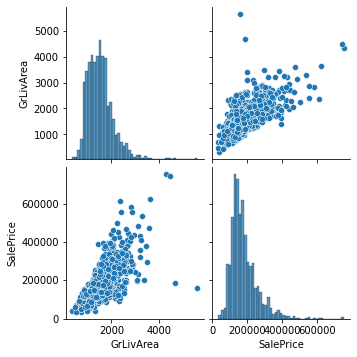

In [8]:
sns.pairplot(df[['GrLivArea', 'SalePrice']]);

La relation entre la variable et la cible a bien un aspect linéaire

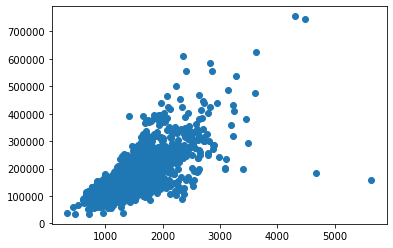

In [9]:
plt.scatter(df.GrLivArea, df.SalePrice);

#### Suppression des outliers extrèmes

In [10]:
df = df.drop(df[(df.GrLivArea > 4000) & (df.SalePrice < 300000)].index)
df.size

118098

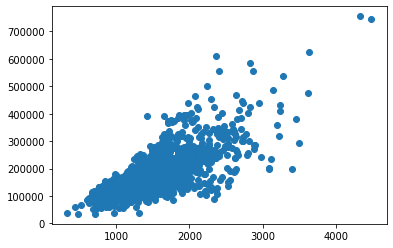

In [11]:
plt.scatter(df.GrLivArea, df.SalePrice);

#### Séparation de la variable explicative et de la cible

In [12]:
# Variables explicatives, une seule
X = df[['GrLivArea']]

# Variable cible
y = df['SalePrice']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

#### Scaling

In [14]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train) # X_train_scaled
X_test = scaler.transform(X_test) # X_test_scaled

#### Standardisation

In [15]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

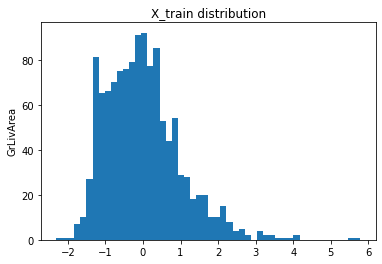

In [16]:
plt.hist(X_train, bins=50)
plt.gca().set(title='X_train distribution', ylabel='GrLivArea');

Supprimer au dessus de 2 ?

### Création des modèles

### LinearRegression

In [17]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)

y_pred_test = lr.predict(X_test)

In [18]:
mse_train = mean_squared_error(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)

print("MSE train lr:", mse_train)
print("MSE test lr:", mse_test)

MSE train lr: 3006769227.362125
MSE test lr: 2324514861.5268574


In [19]:
mae_train = mean_absolute_error(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)

print("MAE train lr:", mae_train)
print("MAE test lr:", mae_test)

mean_price = df['SalePrice'].mean()

print("\nRelative error", mae_test / mean_price)

MAE train lr: 37917.93851433352
MAE test lr: 35144.46720684592

Relative error 0.1942403150738423


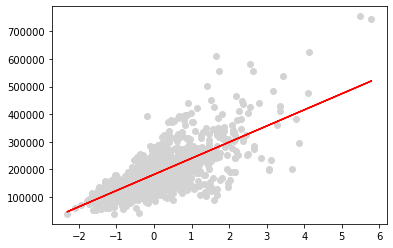

In [20]:
plt.scatter(X_train, y_train,color='lightgrey');
plt.plot(X_train, lr.predict(X_train),color='r');

### polynomial regression

In [21]:
poly_feature_extractor = PolynomialFeatures(degree = 3)

# Application de la transformation sur X_train et X_test
X_train_poly = poly_feature_extractor.fit_transform(X_train)
X_test_poly = poly_feature_extractor.transform(X_test)

In [22]:
polyreg = LinearRegression()

polyreg.fit(X_train_poly, y_train)

y_pred_train = polyreg.predict(X_train_poly)
print("MAE Train:", mean_absolute_error(y_train, y_pred_train))

y_pred_test = polyreg.predict(X_test_poly)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("MAE Test:", mae_test)

print("\nRelative error", mae_test / mean_price)

MAE Train: 37097.61653020484
MAE Test: 35093.2558490766

Relative error 0.19395727449707312


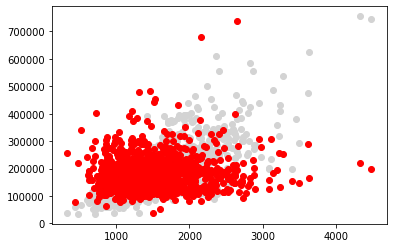

In [23]:
plt.scatter(X, y,color='lightgrey');
plt.scatter(X.head(1239), y_pred_train.reshape(-1, 1),color='r'); # .sort_values(by=X.columns[0])

### Lasso

In [54]:
lso = Lasso(alpha=0.1)

In [55]:
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)

y_pred_test = lr.predict(X_test)

In [56]:
mae_train = mean_absolute_error(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)

print("MAE train lr:", mae_train)
print("MAE test lr:", mae_test)

mean_price = df['SalePrice'].mean()

print("\nRelative error", mae_test / mean_price)

MAE train lr: 37917.93851433352
MAE test lr: 35144.46720684592

Relative error 0.1942403150738423


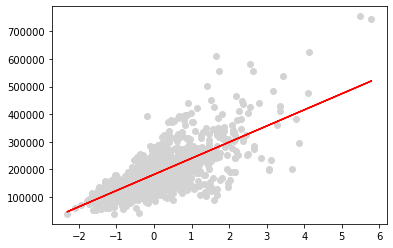

In [57]:
plt.scatter(X_train, y_train,color='lightgrey');
plt.plot(X_train, lr.predict(X_train),color='r');